In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import json
from tqdm import tqdm
import string

import os
if os.getcwd().split(os.sep)[-1] == 'notebooks':
    os.chdir('..')
print(os.getcwd())


/home/spetryk/vl-attention


In [2]:
coco=COCO('data/COCO/annotations/instances_train2014.json')
#coco=COCO('data/COCO/annotations/instances_val2014.json')

loading annotations into memory...
Done (t=14.85s)
creating index...
index created!


In [4]:
root = 'data/COCO/COCO_gender'
train_ids = np.loadtxt(os.path.join(root, 'biased_split', 'train.ids.txt'), dtype=float)
test_ids = np.loadtxt(os.path.join(root, 'biased_split', 'test.ids.txt'), dtype=float)

val_man = np.loadtxt(os.path.join(root, 'balanced_split', 'val_man.txt'), dtype=float)
val_woman = np.loadtxt(os.path.join(root, 'balanced_split', 'val_woman.txt'), dtype=float)
test_man = np.loadtxt(os.path.join(root, 'balanced_split', 'test_man.txt'), dtype=float)
test_woman = np.loadtxt(os.path.join(root, 'balanced_split', 'test_woman.txt'), dtype=float)

print('*** Biased ***')
print('Num train ids: {}'.format(len(train_ids)))
print('Num test ids: {}'.format(len(test_ids)))
print()
print('*** Balanced ***')
print('Num val man ids: {}'.format(len(val_man)))
print('Num val woman ids: {}'.format(len(val_woman)))
print('Num test man ids: {}'.format(len(test_man)))
print('Num test woman ids: {}'.format(len(test_woman)))


*** Biased ***
Num train ids: 22966
Num test ids: 5510

*** Balanced ***
Num val man ids: 500
Num val woman ids: 500
Num test man ids: 500
Num test woman ids: 500


In [4]:
with open(os.path.join(root, 'captions_only_valtrain2014.json')) as f:
    captions = json.load(f)
captions = captions['annotations']
print(len(captions))

id2captions = {}
for entry in tqdm(captions):
    cap_id = entry['image_id']
    if cap_id not in id2captions:
        id2captions[cap_id] = []
    id2captions[cap_id].append(entry['caption'])
    
print(captions[0])

 16%|█▌        | 96780/616767 [00:00<00:00, 967794.00it/s]

616767


100%|██████████| 616767/616767 [00:00<00:00, 765801.33it/s]

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


In [5]:
man_word_list_synonyms = ['boy', 'brother', 'dad', 'husband', 'man',       \
        'groom', 'male','guy', 'dude', 'policeman', 'father',              \
        'son', 'fireman', 'actor','gentleman', 'boyfriend',                \
        'mans', 'his', 'obama', 'businessman', 'he', 'cowboy']
woman_word_list_synonyms = ['girl', 'sister', 'mom', 'wife', 'woman',      \
        'bride', 'female', 'lady',  'actress', 'nun', 'girlfriend',        \
        'her', 'she', 'mother', 'daughter', 'businesswoman', 'cowgirl']
person_word_list_synonyms = ['person', 'child', 'kid', 'teenager',         \
        'someone', 'player', 'rider',  'skiier','chef',                    \
        'snowboarder', 'surfer',  'hipster',   'skateboarder', 'adult',    \
        'baby', 'skier', 'diver', 'bicycler', 'hiker', 'student',          \
        'shopper', 'cyclist', 'officer', 'teen', 'worker', 'passenger',    \
        'cook', 'pedestrian', 'employee',  'driver', 'skater',              \
        'toddler',  'fighter', 'patrol', 'cop', 'server', 'carrier',       \
        'player', 'motorcyclist', 'carpenter', 'owner',  'individual',     \
        'bicyclist', 'boarder',  'boater', 'painter', 'artist',            \
        'citizen', 'staff', 'biker', 'technician', 'hand',  'baker',       \
        'manager', 'plumber', 'hands', 'performer', 'rollerblader',        \
        'farmer', 'athlete', 'pitcher', 'soldier']


In [13]:
def fullfile(filename, split='train'):
    return os.path.join('data/COCO/{}2014'.format(split), filename)

In [7]:
# ids = coco.loadImgs(train_ids)
# for i in range(10):
#     entry = ids[i]
#     img = Image.open(fullfile(entry['file_name']))
#     title = ''
#     assert entry['id'] in id2captions
#     for cap in id2captions[entry['id']]:
#         title = title + cap +'\n'
#     plt.title(title)
#     plt.imshow(img)
#     plt.show()
# print(ids[0])
    

In [8]:
def count_man_woman_person(caption_list):
    exclude = set(string.punctuation)

    num_man = 0
    num_woman = 0
    num_person = 0
    num_else = 0
    num_multiple = 0
    for c in caption_list:
        # Lowercase and remove punctuation
        c = c.lower()
        c = ''.join(ch for ch in c if ch not in exclude)
        c = c.split(' ')
        
        man, woman, person = 0,0,0
        for w in man_word_list_synonyms:
            if w in c:
                man = 1
        for w in woman_word_list_synonyms:
            if w in c:
                woman = 1
        for w in person_word_list_synonyms:
            if w in c:
                person = 1
                
        if (man + woman) > 1:
            num_multiple += 1
        elif (man + woman + person) == 0:
            num_else += 1
            #print('Caption with no people words: {}'.format(' '.join(c)))
        else:
            num_man += man
            num_woman += woman
            num_person += person
            
        #print(c, man, woman, person)
    #print(num_man, num_woman, num_person, num_else, num_multiple)
    return {
        'num_man': num_man,
        'num_woman': num_woman,
        'num_person': num_person,
        'num_else': num_else,
        'num_multiple': num_multiple
    }


class ImageInfo():
    def __init__(self, coco_entry, caption_list):
        self.filename = coco_entry['file_name']
        self.id = coco_entry['id']
        self.captions = caption_list
        self.num_man      = 0
        self.num_woman    = 0
        self.num_person   = 0
        self.num_else     = 0 # no man, woman, or person words
        self.num_multiple = 0 # caption mentions multiple categories of people
 


id2info = {}
coco_entries = coco.loadImgs(train_ids.astype(int))
#coco_entries = coco.loadImgs(test_woman.astype(int))
for entry in coco_entries:
    assert entry['id'] not in id2info
    info = ImageInfo(entry, id2captions[entry['id']])
    #print(entry['id'])
    counts = count_man_woman_person(info.captions)
    info.num_man = counts['num_man']
    info.num_woman = counts['num_woman']
    info.num_person = counts['num_person']
    info.num_else = counts['num_else']
    info.num_multiple = counts['num_multiple']
    
    # Only include images where the captions don't conflict on man/woman,
    # and captions that include at least one person mentioned
    if info.num_multiple == 0 and \
        (info.num_man + info.num_woman + info.num_person) > 0:
        id2info[entry['id']] = info

In [9]:

print(len(coco_entries))
print(len(list(id2info.keys())))

22966
22506


In [12]:
for i in range(5):
    print(train_ids[i])
    print(coco_entries[i]['id'])


384029.0
384029
222016.0
222016
69675.0
69675
547471.0
547471
90570.0
90570


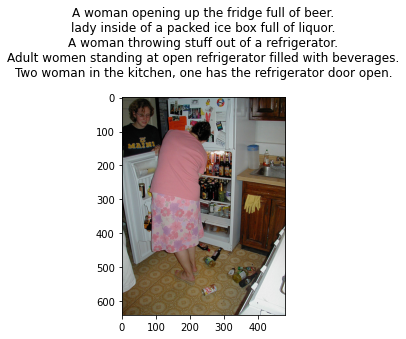

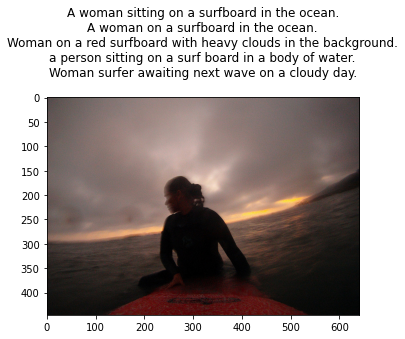

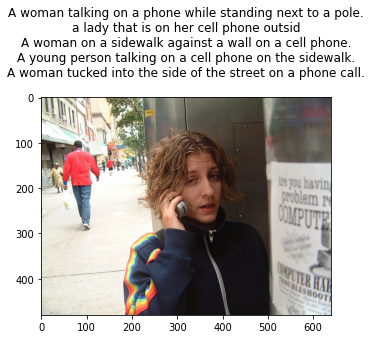

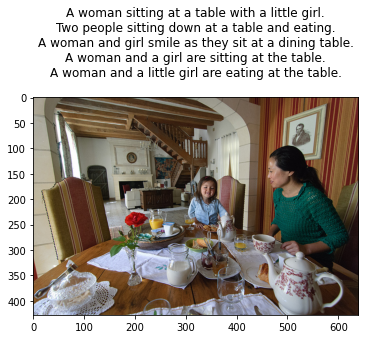

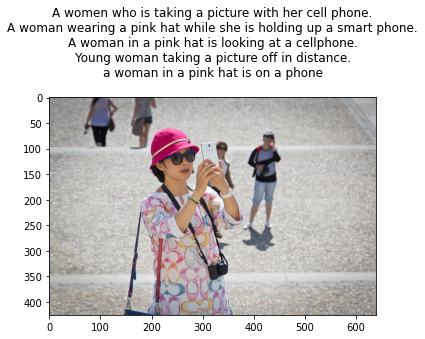

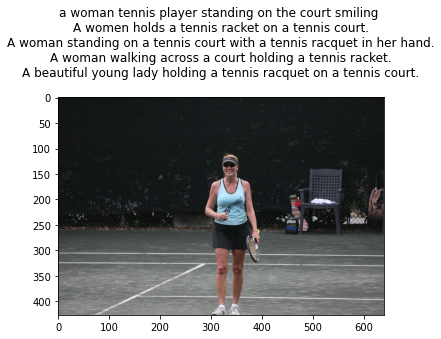

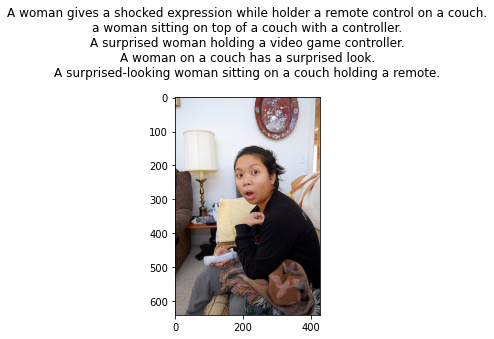

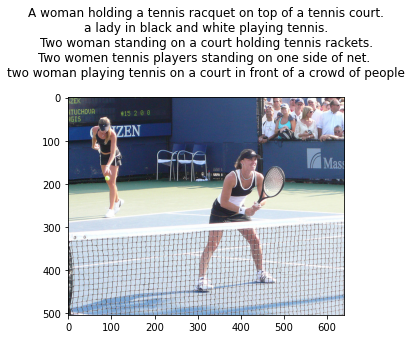

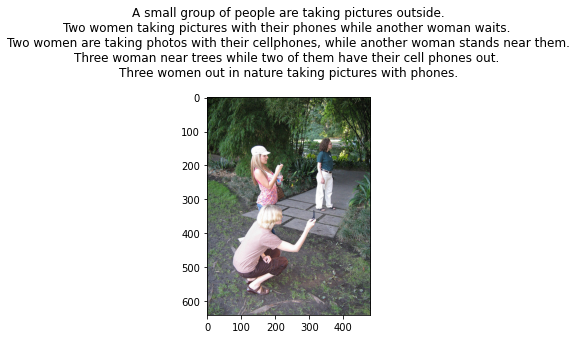

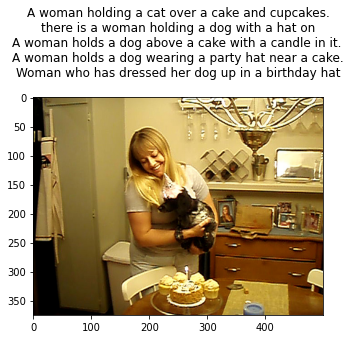

In [37]:
keys = list(id2info.keys())
for i in range(10):
    info = id2info[keys[i+30]]
    img = Image.open(fullfile(info.filename, split='val'))
    title = ''
    for cap in info.captions:
        title = title + cap +'\n'
    plt.title(title)
    plt.imshow(img)
    plt.show()


In [38]:
# maps min number of instances allowed to number of images in each class
# [man, woman, person]
# is labeled as person iff. it does not qualify as man or woman, and has min number labeled as person as well
stats = {1:[0,0,0], 2:[0,0,0], 3:[0,0,0], 4:[0,0,0], 5:[0,0,0]}
for min_allowed, counts in stats.items():
    for info in id2info.values():
        assert info.num_multiple == 0 and (info.num_man + info.num_woman + info.num_person) > 0
        if info.num_man >= min_allowed:
            counts[0] += 1
        elif info.num_woman >= min_allowed:
            counts[1] += 1
        elif info.num_person >= min_allowed:
            counts[2] += 1
    stats[min_allowed] = counts
    print('Counts for {}: {}'.format(min_allowed, counts))
    print('Total for {}: {}'.format(min_allowed, counts[0]+counts[1]+counts[2]))


Counts for 1: [5, 482, 0]
Total for 1: 487
Counts for 2: [1, 452, 12]
Total for 2: 465
Counts for 3: [0, 418, 21]
Total for 3: 439
Counts for 4: [0, 369, 7]
Total for 4: 376
Counts for 5: [0, 231, 3]
Total for 5: 234


In [17]:
import torch
x = np.concatenate((val_woman, val_man))
print(x.shape)

print(torch.Tensor(x))

(1000,)
tensor([1.0249e+04, 4.8744e+05, 8.6036e+04, 1.1471e+05, 3.3180e+05, 2.4601e+04,
        3.0108e+05, 1.3929e+05, 1.3725e+05, 2.4609e+04, 4.5099e+04, 3.2812e+04,
        4.8132e+05, 5.1410e+05, 3.0111e+05, 5.5711e+05, 4.0352e+05, 4.9363e+05,
        5.7966e+05, 3.4271e+05, 5.5375e+04, 1.5419e+05, 3.8307e+05, 3.2983e+05,
        5.6126e+05, 4.8345e+05, 5.6234e+05, 6.5661e+04, 3.8926e+05, 1.1892e+05,
        5.1214e+05, 2.5410e+05, 4.2204e+05, 2.9767e+05, 5.3568e+05, 3.1146e+05,
        3.5857e+05, 2.2705e+04, 4.6714e+05, 4.1799e+05, 1.8861e+05, 5.6954e+05,
        6.5736e+04, 3.6884e+05, 3.2584e+05, 3.9138e+05, 4.1596e+05, 2.1731e+05,
        4.3850e+05, 3.1972e+05, 4.0369e+05, 5.0405e+05, 3.5045e+05, 4.5899e+05,
        2.8082e+05, 3.3202e+05, 1.3542e+05, 1.0676e+05, 9.0374e+04, 5.4708e+05,
        3.2181e+05, 8.8345e+04, 1.7437e+05, 1.9281e+05, 3.9146e+05, 4.5700e+05,
        1.6209e+05, 5.1025e+05, 5.5122e+05, 2.0511e+05, 2.3788e+05, 4.1811e+05,
        8.6334e+04, 2.1946e+05, 

In [19]:
np.concatenate((np.ones(4), np.zeros(1), np.ones(3)))

array([1., 1., 1., 1., 0., 1., 1., 1.])

In [21]:
torch.cat((torch.ones(3), torch.zeros(1), torch.ones(2)))

tensor([1., 1., 1., 0., 1., 1.])

In [5]:
coco_entries = coco.loadImgs(train_ids.astype(int))


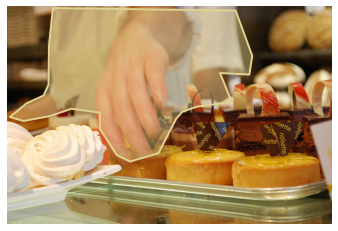

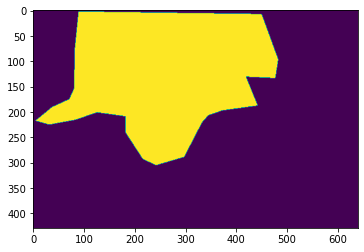

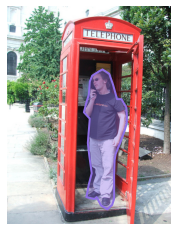

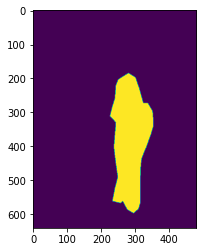

None
> <ipython-input-30-58d9b7604c49>(10)<module>()
      8         breakpoint()
      9 
---> 10     img = Image.open(fullfile(entry['file_name'], split='train'))
     11     fig, ax = plt.subplots()
     12     ax.axis('off')

ipdb> len(anns)
2
ipdb> n
None
> <ipython-input-30-58d9b7604c49>(11)<module>()
      9 
     10     img = Image.open(fullfile(entry['file_name'], split='train'))
---> 11     fig, ax = plt.subplots()
     12     ax.axis('off')
     13     ax.imshow(img)

ipdb> n
None
> <ipython-input-30-58d9b7604c49>(12)<module>()
     10     img = Image.open(fullfile(entry['file_name'], split='train'))
     11     fig, ax = plt.subplots()
---> 12     ax.axis('off')
     13     ax.imshow(img)
     14     coco.showAnns(anns)

ipdb> n
None
> <ipython-input-30-58d9b7604c49>(13)<module>()
     11     fig, ax = plt.subplots()
     12     ax.axis('off')
---> 13     ax.imshow(img)
     14     coco.showAnns(anns)
     15     plt.show()

ipdb> n
None
> <ipython-input-30-58d9b7604c49>(14

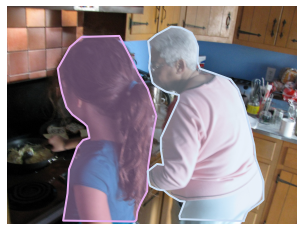

None
> <ipython-input-30-58d9b7604c49>(17)<module>()
     15     plt.show()
     16 
---> 17     mask = coco.annToMask(anns[0])
     18     plt.imshow(mask)
     19     plt.show()

ipdb> anns[0].keys()
dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
ipdb> anns[0]['bbox']
[111.1, 64.72, 217.89, 409.89]
ipdb>  anns[0]['bbox'][2] *  anns[0]['bbox'][3]
89310.93209999999
ipdb> 217*409
88753
ipdb> 217.89*409.89
89310.93209999999


In [ ]:
person_cat = 1
for i in range(10):
    entry = coco_entries[i]
    annIds = coco.getAnnIds(imgIds=entry['id'], catIds=[person_cat], iscrowd=None)
    anns = coco.loadAnns(annIds)
    
    if len(anns) > 1:
        breakpoint()

    img = Image.open(fullfile(entry['file_name'], split='train'))
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(img)
    coco.showAnns(anns)
    plt.show()

    mask = coco.annToMask(anns[0])
    plt.imshow(mask)
    plt.show()
    
    

In [ ]:

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
for i,n in enumerate(nms):
    print('{}: {}'.format(i,n))

In [29]:
def find_largest_bbox(annotations):
    """
    annotations: list of coco-style annotations.
    
    if only one annotation, return annotations.
    if more than one, find annotation that has largest
    bounding box by area, and return list of length 1
    containing only that annotation.
    """
    if len(annotations) == 1:
        return annotations
    else:
        max_area   = -1
        best_index = -1
        for i,annot in enumerate(annotations):
            area = annot['bbox'][2] * annot['bbox'][3]
            if area > max_area:
                max_area = area
                best_index = i
    

[{'segmentation': [[170.24,
    309.05,
    164.34,
    309.05,
    160.68,
    309.05,
    158.44,
    308.64,
    158.03,
    308.44,
    156.81,
    306.61,
    156.81,
    305.18,
    158.03,
    292.57,
    158.44,
    290.33,
    159.05,
    288.71,
    158.84,
    288.09,
    156.61,
    288.09,
    155.39,
    289.93,
    153.35,
    289.72,
    152.74,
    289.52,
    152.74,
    288.09,
    151.52,
    286.47,
    152.74,
    285.25,
    154.57,
    283.62,
    156.81,
    282.19,
    158.23,
    279.14,
    159.05,
    274.67,
    160.27,
    271.21,
    160.27,
    266.73,
    159.05,
    262.66,
    156.4,
    260.63,
    153.76,
    243.54,
    154.17,
    241.71,
    157.22,
    241.91,
    160.07,
    242.11,
    163.73,
    241.5,
    165.15,
    241.5,
    166.58,
    242.93,
    167.8,
    245.17,
    168.81,
    247.2,
    169.83,
    251.07,
    167.8,
    255.14,
    166.78,
    256.15,
    168.0,
    258.8,
    170.44,
    260.63,
    173.29,
    264.29,
    175.